In [21]:
!pip install requests scikit-learn pandas tensorflow pillow matplotlib


In [22]:
import requests
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import joblib  # For loading pre-trained models
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input


In [23]:
# Prompt user to enter city
city_name = input("Enter the city name: ")

API_KEY = "cf4860c7ef9ccc070a2a3c0a48d63aca"  # Replace with your OpenWeatherMap API key
forecast_url = "https://api.openweathermap.org/data/2.5/forecast"

params = {
    'q': city_name,
    'appid': API_KEY,
    'units': 'metric'
}

response = requests.get(forecast_url, params=params)
forecast_data = response.json()

if forecast_data.get("cod") != "200":
    print(f"Error fetching forecast: {forecast_data.get('message','Unknown error')}")
    daily_weather = []
else:
    # Aggregate 3-hour interval data into daily averages
    daily_weather = []
    for i in range(0, len(forecast_data['list']), 8):  # 8 * 3h = 24h
        day_data = forecast_data['list'][i:i+8]
        temp_avg = np.mean([d['main']['temp'] for d in day_data])
        humidity_avg = np.mean([d['main']['humidity'] for d in day_data])
        rainfall_sum = np.sum([d.get('rain', {}).get('3h', 0) for d in day_data])
        daily_weather.append({'temp': temp_avg, 'humidity': humidity_avg, 'rainfall': rainfall_sum})

print("Daily weather forecast for next days:")
for idx, day in enumerate(daily_weather, start=1):
    print(f"Day {idx}: Temp={day['temp']:.2f}°C, Humidity={day['humidity']:.2f}%, Rainfall={day['rainfall']:.2f}mm")


Enter the city name: chennai
Daily weather forecast for next days:
Day 1: Temp=29.76°C, Humidity=69.62%, Rainfall=1.68mm
Day 2: Temp=28.98°C, Humidity=70.12%, Rainfall=3.30mm
Day 3: Temp=28.23°C, Humidity=72.50%, Rainfall=12.06mm
Day 4: Temp=28.19°C, Humidity=71.88%, Rainfall=9.68mm
Day 5: Temp=27.21°C, Humidity=75.88%, Rainfall=8.29mm


In [24]:
# Currently not used in weighted spread, but can be kept for future extensions
if daily_weather:
    temp_avg = np.mean([d['temp'] for d in daily_weather])
    humidity_avg = np.mean([d['humidity'] for d in daily_weather])
    rainfall_avg = np.mean([d['rainfall'] for d in daily_weather])
    input_features = np.array([[temp_avg, humidity_avg, rainfall_avg]])


In [25]:
# Build EfficientNetB0 model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(11, activation="softmax")(x)  # 11 disease classes
model = Model(inputs=base_model.input, outputs=outputs)

print("Model architecture created.")

# Uncomment and provide path if fine-tuned weights are available
# model.load_weights("path_to_finetuned_weights.h5")
# print("Fine-tuned weights loaded.")


Model architecture created.


In [26]:
PLANT_DISEASE_CLASSES = [
    "Apple Scab", "Apple Black Rot", "Apple Cedar Apple Rust",
    "Tomato Early Blight", "Tomato Late Blight", "Tomato Leaf Mold",
    "Potato Early Blight", "Potato Late Blight",
    "Grape Black Rot", "Grape Esca (Black Measles)",
    "Healthy"
]


In [8]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((224,224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


In [27]:
def predict_disease(image_path):
    img_array = preprocess_image(image_path)
    preds = model.predict(img_array)
    top_idx = np.argmax(preds)
    pred_class = PLANT_DISEASE_CLASSES[top_idx]
    confidence = preds[0][top_idx]
    return pred_class, confidence


In [28]:
def parse_species_disease(pred_class):
    if pred_class == "Healthy":
        return "Healthy", "Healthy"
    parts = pred_class.split(' ', 1)
    if len(parts) == 2:
        species, disease = parts
    else:
        species, disease = pred_class, "Unknown"
    return species, disease


In [29]:
# Base spread dictionary
spread_time_map = {
    ("Apple", "Scab"): {"hours_per_acre": 36, "days_per_acre": 1.5},
    ("Apple", "Black Rot"): {"hours_per_acre": 48, "days_per_acre": 2},
    ("Apple", "Cedar Apple Rust"): {"hours_per_acre": 72, "days_per_acre": 3},
    ("Tomato", "Early Blight"): {"hours_per_acre": 48, "days_per_acre": 2},
    ("Tomato", "Late Blight"): {"hours_per_acre": 24, "days_per_acre": 1},
    ("Tomato", "Leaf Mold"): {"hours_per_acre": 60, "days_per_acre": 2.5},
    ("Potato", "Early Blight"): {"hours_per_acre": 36, "days_per_acre": 1.5},
    ("Potato", "Late Blight"): {"hours_per_acre": 18, "days_per_acre": 0.75},
    ("Grape", "Black Rot"): {"hours_per_acre": 36, "days_per_acre": 1.5},
    ("Grape", "Esca (Black Measles)"): {"hours_per_acre": 72, "days_per_acre": 3},
    ("Healthy", "Healthy"): {"hours_per_acre": 0, "days_per_acre": 0},
}

# ✅ Weighted spread using temperature, humidity, rainfall
def estimate_weighted_spread(species, disease, temperature, humidity, rainfall):
    base = spread_time_map.get((species, disease), {"hours_per_acre": None, "days_per_acre": None})
    if base["days_per_acre"] is None:
        return {"hours_per_acre": None, "days_per_acre": None}

    # Weight factors
    temp_factor = 1.0
    if temperature is not None:
        if 20 <= temperature <= 30:
            temp_factor = 0.9
        elif temperature < 15 or temperature > 35:
            temp_factor = 1.2

    humidity_factor = 1.0
    if humidity is not None:
        if humidity > 80:
            humidity_factor = 0.8
        elif humidity < 40:
            humidity_factor = 1.2

    rainfall_factor = 1.0
    if rainfall is not None:
        if rainfall > 10:
            rainfall_factor = 0.85
        elif rainfall == 0:
            rainfall_factor = 1.1

    weighted_days = base["days_per_acre"] * temp_factor * humidity_factor * rainfall_factor
    weighted_hours = base["hours_per_acre"] * temp_factor * humidity_factor * rainfall_factor

    return {"hours_per_acre": round(weighted_hours, 2), "days_per_acre": round(weighted_days, 2)}


In [30]:
def plot_spread_time(species, disease, spread):
    if spread["hours_per_acre"] is None:
        print(f"No spread data found for {species} - {disease}")
        return
    plt.bar(["Hours/Acre", "Days/Acre"], [spread["hours_per_acre"], spread["days_per_acre"]],
            color=['orange', 'green'])
    plt.title(f"Disease Spread Time\n{species} | {disease}")
    plt.ylabel("Time")
    plt.show()


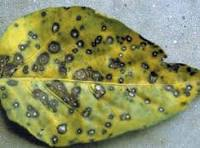

In [33]:
from IPython.display import display
image_path = "/content/image.jpg"  # Replace with your image path
img = Image.open(image_path)
display(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Predicted: Tomato Late Blight with confidence 20.91%
Species detected: Tomato, Disease detected: Late Blight
Day 1 weighted spread: 21.6 hours/acre, 0.9 days/acre
Day 2 weighted spread: 21.6 hours/acre, 0.9 days/acre
Day 3 weighted spread: 18.36 hours/acre, 0.77 days/acre
Day 4 weighted spread: 21.6 hours/acre, 0.9 days/acre
Day 5 weighted spread: 21.6 hours/acre, 0.9 days/acre

Estimated total spread over forecast period: 104.76 hours/acre, 4.37 days/acre


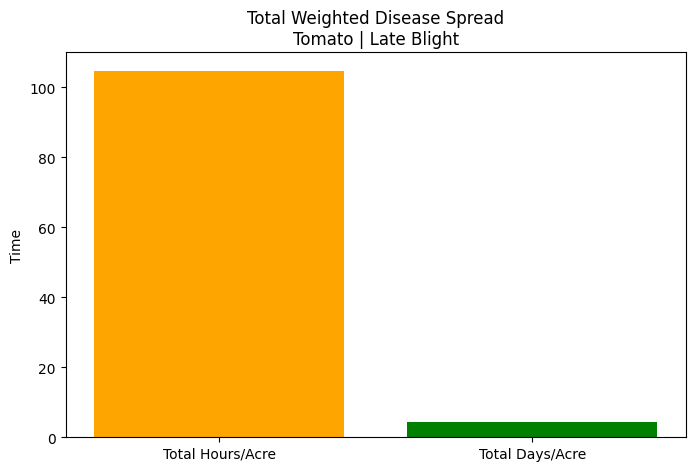

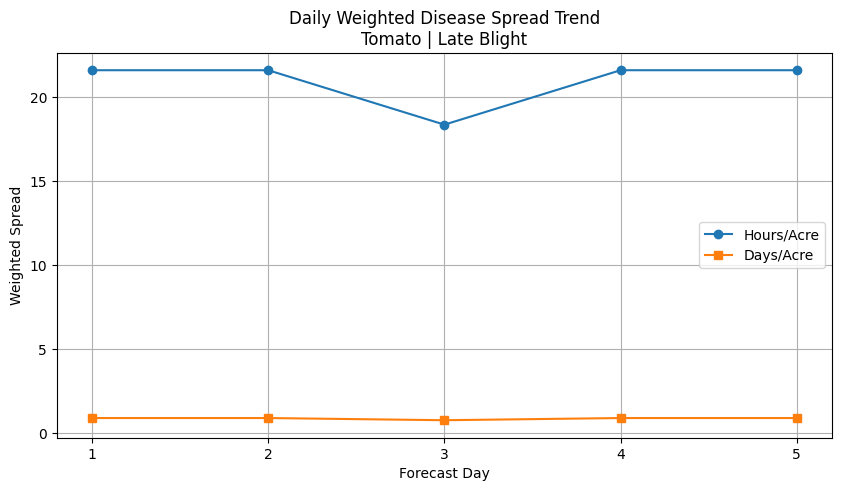

In [34]:
# Predict disease
pred_class, confidence = predict_disease(image_path)
print(f"Predicted: {pred_class} with confidence {confidence*100:.2f}%")

# Parse species and disease
species, disease = parse_species_disease(pred_class)
print(f"Species detected: {species}, Disease detected: {disease}")

# ✅ Forecast-based weighted spread calculation
if not daily_weather:
    print("No forecast data available to calculate spread.")
else:
    total_days = 0
    total_hours = 0
    day_hours_list = []
    day_days_list = []

    for idx, day in enumerate(daily_weather, start=1):
        spread_day = estimate_weighted_spread(species, disease,
                                              day['temp'], day['humidity'], day['rainfall'])
        print(f"Day {idx} weighted spread: {spread_day['hours_per_acre']} hours/acre, {spread_day['days_per_acre']} days/acre")
        total_days += spread_day['days_per_acre']
        total_hours += spread_day['hours_per_acre']
        day_hours_list.append(spread_day['hours_per_acre'])
        day_days_list.append(spread_day['days_per_acre'])

    print(f"\nEstimated total spread over forecast period: {round(total_hours,2)} hours/acre, {round(total_days,2)} days/acre")

    # Plot total weighted spread
    plt.figure(figsize=(8,5))
    plt.bar(["Total Hours/Acre", "Total Days/Acre"], [total_hours, total_days], color=['orange', 'green'])
    plt.title(f"Total Weighted Disease Spread\n{species} | {disease}")
    plt.ylabel("Time")
    plt.show()

    # ✅ Optional: Plot daily trend for visualization
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(day_hours_list)+1), day_hours_list, marker='o', label='Hours/Acre')
    plt.plot(range(1, len(day_days_list)+1), day_days_list, marker='s', label='Days/Acre')
    plt.xticks(range(1, len(day_hours_list)+1))
    plt.xlabel("Forecast Day")
    plt.ylabel("Weighted Spread")
    plt.title(f"Daily Weighted Disease Spread Trend\n{species} | {disease}")
    plt.legend()
    plt.grid(True)
    plt.show()
